In [ ]:
!pip install qutip

First we have to import necessary libraries.

In [ ]:
import math
import numpy as np
from scipy import linalg
from scipy import integrate
from scipy import sparse
import scipy.optimize as optimize
import qutip as qt
import os
import random
import matplotlib.pyplot as plt
import itertools

We define functions for spin operators.

In [ ]:
# Dictionary mapping operator specifications to the corresponding operator functions
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}

def mkSpinOp(dims, specs):
    """Returns a tensor product of operators based on given dimensions and specifications.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.
    specs :
        List of index-specification pairs indicating which operator to modify and how.

    Returns
    -------
    qobj
        The matrix (tensor product of individual operators).

    Examples
    --------
    >>> spin_op = mkSpinOp([3, 4, 2], [(0, 'x'), (1, 'y'), (2, 'z')])
    >>> spin_op
    [[3, 4, 2], [3, 4, 2]]
    """

    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)

def idOp(dims):
    """Returns the tensor product of identity operators with given dimensions.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.

    Returns
    -------
    qobj
        The identity matrix (tensor product of individual operators).

    Examples
    --------
    >>> id_op = idOp([3, 4, 2])
    >>> id_op.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    return mkSpinOp(dims, [])

def zeroOp(dims):
    """Returns the tensor product of zero operators with given dimensions.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.

    Returns
    -------
    qobj
        The zero matrix (tensor product of individual operators).

    Examples
    --------
    >>> zero_op = zeroOp([3, 4, 2])
    >>> zero_op.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    d = np.prod(dims)
    return qt.Qobj(sparse.csr_matrix((d, d), dtype=np.float64),
                       dims=[list(dims)]*2, type="oper", isherm=True)

We define functions for Hamiltonian operators.

In [ ]:
def mkH1(dims, ind, parvec):
    """Returns the Hamiltonian operator based on the given dimensions, index, and parameter vector.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.
    ind : int
        Index indicating which operator to modify.
    parvec : list of float
        List of parameter values for each spin component. (???)

    Returns
    -------
    qutip.qobj
        The Hamiltonian operator.

    Examples
    --------
    >>> H1 = mkH1([3, 4, 2], 1, [1.0, 0.5, 0.1])
    >>> H1.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    axes = ['x', 'y', 'z']
    components = [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0]
    if components:
        return sum(components)
    else:
        return zeroOp(dims)

def mkH12(dims, ind1, ind2, parmat):
    """Returns the Hamiltonian operator based on the given dimensions, indices, and parameter matrix.

    Parameters
    ----------
    dims : list of int
        List of dimensions of individual operators.
    ind1 : int
        Index indicating the first operator to modify.
    ind2 : int
        Index indicating the second operator to modify.
    parmat : np.ndarray
        Parameter matrix specifying the coupling strengths. (???)

    Returns
    -------
    qutip.qobj
        The Hamiltonian operator.

    Examples
    --------
    >>> H12 = mkH12([3, 4, 2], 0, 1, np.array([[1.0, 0.5, -0.3], [0.5, 0.0, 0.2], [-0.3, 0.2, 0.7]]))
    >>> H12.dims
    [[3, 4, 2], [3, 4, 2]]
    """

    axes = ['x', 'y', 'z']
    components = []
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                components.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    if components:
        return sum(components)
    else:
        return zeroOp(dims)

We define function for the dense of an operator.

In [ ]:
def dense(op):
    """Returns the dense array representation of the given operator.

    Parameters
    ----------
    op : Union[qutip.qobj.Qobj, scipy.sparse.csc_matrix]
        The input operator.

    Returns
    -------
    numpy.ndarray
        The dense array representation of the operator.

    Examples
    --------
    >>> operator = qt.Qobj([[1, 2], [3, 4]])

    # Get the dense array representation of the operator
    >>> dense_op = dense(operator)
    array([[1.+0.j, 2.+0.j],
        [3.+0.j, 4.+0.j]])
    """

    if type(op) is qt.qobj.Qobj:
        return np.asarray(op.data.todense())
    else:
        return np.asarray(op.todense())

$$
\text{Trace}({\rho(t) Z})
$$

for

$$
\rho(t) = U(t)\rho(0) U^{\dagger}(t)
$$

We define functions for computing expectation values.

In [ ]:
def expvalsConstH(Heff, rho0, ops, dt, nr_steps):
    """Returns the expectation values of operators and the final density matrix.

    Parameters
    ----------
    Heff : numpy.ndarray
        The effective Hamiltonian.
    rho0 : numpy.ndarray
        The initial density matrix.
    ops : list of numpy.ndarray
        List of operators for which expectation values are computed.
    dt : float
        The time step size.
    nr_steps : int
        The number of steps in the evolution.

    Returns
    -------
    obs : numpy.ndarray
        The expectation values of the operators over time.
    rhot : numpy.ndarray
        The final density matrix.

    Examples
    --------
    >>> Heff = np.array([[1, 0], [0, -1]])
    >>> rho0 = np.array([[1, 0], [0, 0]])
    >>> ops = [np.array([[1, 0], [0, 1]]), np.array([[0, 1], [1, 0]])]
    >>> dt = 0.1
    >>> nr_steps = 10

    # Compute the expectation values and final density matrix
    >>> obs, rhot = expvalsConstH(Heff, rho0, ops, dt, nr_steps)
    >>> obs
    array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
    >>> rhot
    array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])
    """

    obs = np.zeros((len(ops),nr_steps))
    rhot = rho0
    U = linalg.expm(-1j*dt*Heff)
    for i in range(nr_steps):
        rhot = U @ rhot @ U.T.conjugate()
        for s in range(len(ops)):
            obs[s,i] = np.real(np.trace(ops[s] @ rhot))

    return obs, rhot

def expvalsPiecewiseConstHt(H0, H1, u, rho0, ops, dt):
    """Returns the expectation values of operators and the final density matrix.

    Parameters
    ----------
    H0 : numpy.ndarray
        The initial fixed Hamiltonian.
    H1 : numpy.ndarray
        The drift (control) time-dependent Hamiltonian.
    u : numpy.ndarray
        The magnetic field (dependent variable).
    rho0 : numpy.ndarray
        The initial density matrix.
    ops : list of numpy.ndarray
        List of operators for which expectation values are computed.
    dt : float
        The time step size.

    Returns
    -------
    obs : numpy.ndarray
        The expectation values of the operators over time.
    rhot : numpy.ndarray
        The final density matrix.

    Examples
    --------
    >>> H0 = np.array([[1, 0], [0, -1]])
    >>> H1 = np.array([[0, 1], [1, 0]])
    >>> u = np.array([0.1, 0.2, 0.3])
    >>> rho0 = np.array([[1, 0], [0, 0]])
    >>> ops = [np.array([[1, 0], [0, 1]]), np.array([[0, 1], [1, 0]])]
    >>> dt = 0.01

    # Compute the expectation values and final density matrix
    >>> obs, rhot = expvalsPiecewiseConstHt(H0, H1, u, rho0, ops, dt)
    >>> obs
    array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.99993267e-05, 9.99883939e-05, 2.79931701e-04]])
    >>> rhot
    array([[9.99964010e-01+1.73472348e-18j, 1.39965851e-04+5.99745641e-03j],
       [1.39965851e-04-5.99745641e-03j, 3.59903691e-05+0.00000000e+00j]])
    """

    nr_steps = len(u)

    obs = np.zeros((len(ops),nr_steps))
    rhot = rho0
    for i in range(nr_steps):
        Hi = H0 + u[i] * H1
        Ui = linalg.expm(-1j*dt*Hi)
        rhot = Ui @ rhot @ Ui.T.conjugate()
        for s in range(len(ops)):
            obs[s,i] = np.real(np.trace(ops[s] @ rhot))

    return obs, rhot

In [ ]:
# exp(iθn⋅σ) = cosθ I+i(n⋅σ)sinθ
# exp(-iudt Sx) = exp(-iudt/2 σx) = cos(udt/2) I - iσx sin(udt/2)
def expm_trotter_H1x(expiA, b1, u, ds, nr_halvings):
    """Returns the approximate exponential of a Hamiltonian.

    Parameters
    ----------
    expiA : numpy.ndarray
        The exponential of the A Hamiltonian.
    b1 : XXX
        xxx
    u : numpy.ndarray
        The magnetic field (dependent variable)
    ds : int
        Time step size.
    nr_halvings : int
        The number of halvings.

    Returns
    -------
    U : numpy.ndarray
        The approximate exponential of the Hamiltonian.

    Examples
    --------
    >>> expiA = np.eye(4)
    >>> b1 = 0.1
    >>> u = 0.1
    >>> ds = 0.01
    >>> nr_halvings = 3

    # Compute the approximate exponential of the Hamiltonian
    >>> U = expm_trotter_H1x(expiA, b1, u, ds, nr_halvings)
    """

    dim_n = expiA.shape[0]//4
    omega = b1*u*ds/2
    c = np.cos(omega)
    s = -1j * np.sin(omega)
    expiB_1 = np.array([[c,s],[s,c]])
    dexpiB_1 = (-1j*ds*b1/2) * np.array([[s,c],[c,s]])
    expiB_12 = np.kron(expiB_1, expiB_1)
    dexpiB_12 = np.kron(dexpiB_1, expiB_1) + np.kron(expiB_1, dexpiB_1)
    # expiB = sparse.kron(expiB_12, sparse.eye(dim_n, format="csr"))
    # dexpiB = sparse.kron(dexpiB_12, sparse.eye(dim_n, format="csr"))
    # expiB = sparse.kron(sparse.csr_matrix(expiB_12), qt.fastsparse.fast_identity(dim_n))
    # dexpiB = sparse.kron(sparse.csr_matrix(dexpiB_12), qt.fastsparse.fast_identity(dim_n))
    expiB = np.kron(expiB_12, np.eye(dim_n))
    dexpiB = np.kron(dexpiB_12, np.eye(dim_n))
    U = expiA @ (expiB @ expiA)
    L = expiA @ (dexpiB @ expiA)
    for i in range(nr_halvings, 0, -1):
        L = U @ L + L @ U
        U = U @ U
    return U

### Gradient functions Eduardo:

In [ ]:
def expvalGradMultiSamples2(H0, H1, u, rho0, op, dt, w):

    nr_samples = len(w)
    nr_steps = len(u)
#    assert(np.mod(nr_steps, nr_samples) == 0)
    nr_substeps = nr_steps//nr_samples

    U_list = []
    for i in range(nr_steps):
        Hi = H0 + u[i] * H1
        Ui, _ = linalg.expm_frechet(-1j*dt*Hi, -1j*dt*H1) #GRADIENT HERE
        U_list.append(Ui)

    obs = 0.0

    Uf = np.eye(H0.shape[0]) # after loop: UnUn-1...U1U0
#    dUUf_list = [] # GRADIENT HERE
#    Ub_list = []   # GRADIENT HERE
    for j in range(nr_samples):
        m = j * nr_substeps
        n = m + nr_substeps
        Ub_list_j = []
        Ub = np.eye(H0.shape[0]) # after loop: UnUn-1...Um
        for i in range(nr_substeps):
            Ui = U_list[i + m] #GRADIENT HERE?
#            dUUf_list.append(dUi @ Uf) #GRADIENT HERE?
            Uf = Ui @ Uf
            Ub_list_j.insert(0, Ub) #GRADIENT HERE?
            Ub = Ub @ U_list[n-1-i][0]
#        for i in range(len(Ub_list)):
#            Ub_list[i] = Ub @ Ub_list[i]
#        Ub_list = Ub_list + Ub_list_j
        A = rho0 @ Uf.T.conjugate()
        #print(A.shape)
        B = A @ op
        BT = B.T
        # obs += w[j] * np.real(np.trace(Uf @ B))
        obs += w[j] * np.real(np.sum(Uf.__mul__(BT)))

    rhot = Uf @ A

    return obs, Uf


def expvalGradMultiSamplesSplitTrotterH1x2(H0, b1, u, rho0, op, dt, w, nr_halvings=4):

    nr_samples = len(w)
    nr_steps = len(u)
#    assert(np.mod(nr_steps, nr_samples) == 0)
    nr_substeps = nr_steps//nr_samples

    dim = rho0.shape[0]

    ds = dt / 2**nr_halvings
    UA = linalg.expm(-1j*ds/2*H0)

    U_list = []
    for i in range(nr_steps):
        # Hi = H0 + u[i] * H1
        # Ui, dUi = linalg.expm_frechet(-1j*dt*Hi, -1j*dt*H1)
        Ui, _ = expm_trotter_H1x(UA, b1, u[i], ds, nr_halvings)
        U_list.append((Ui,dUi))

    obs = 0.0

    Uf = np.eye(dim) # after loop: UnUn-1...U1U0
#    dUUf_list = [] # [dU0, dU1U0, dU2U1U0, dU3U2U1U0, ..., dUnUn-1...U1U0] #GRADIENT HERE
    Ub_list = []   # [Un...U2U1, Un...U2, ..., UnUn-1Un-2, UnUn-1, Un, 1] #GRADIENT HERE
    for j in range(nr_samples):
        m = j * nr_substeps
        n = m + nr_substeps
        Ub_list_j = []
        Ub = np.eye(dim) # after loop: UnUn-1...Um
        for i in range(nr_substeps):
            Ui, dUi = U_list[i + m]
#            dUUf_list.append(dUi @ Uf) #GRADIENT HERE
            Uf = Ui @ Uf
            Ub_list_j.insert(0, Ub)
            Ub = Ub @ U_list[n-1-i][0]
        for i in range(len(Ub_list)):
            Ub_list[i] = Ub @ Ub_list[i]
        Ub_list = Ub_list + Ub_list_j
        A = rho0 @ Uf.T.conjugate()
        #print(A.shape)
        B = A @ op
        BT = B.T
        # obs += w[j] * np.real(np.trace(Uf @ B))
        obs += w[j] * np.real(np.sum(Uf.__mul__(BT)))


    rhot = Uf @ A

    return obs, Uf

In [ ]:
def fun2(u, H0, H1, rho0, obs, dt, w, minimize):
    if type(H1) == float:
        ys,_ = expvalGradMultiSamplesSplitTrotterH1x2(H0, H1, u, rho0, obs, dt, w)
    else:
        ys,_ = expvalGradMultiSamples2(H0, H1, u, rho0, obs, dt, w)
    if not minimize:
        ys = -ys
        #grad = -grad

    return ys

We look at a generalisation of the system studied in this paper: https://aip.scitation.org/doi/abs/10.1063/1.5131557

In [ ]:
def mkSystem(b0, b1, kS, k0):

    g = 2.00231930436256 #electron g-factor
    beta = 9.274009994e-24 #bohr magneton
    hbar = 6.62607015e-34/(2*np.pi) #hbar
    mT = g*beta/hbar*1e-9 # mT -> Mrad/s

    omega0 = b0*mT
    omega1 = b1*mT
    Is = [0.5, 0.5, 0.5, 0.5, 0.5]
    indE = [0, 0, 0, 1, 1]
    hfcs = np.array([0.2, 0.5, 1.0, 0.2, 0.3]) * mT # mT -> Mrad/s
    jex = 1 * 2*math.pi

    dims = [2, 2] + [round(2*Is[i]+1) for i in range(len(Is))]
    Hhfc = sum(mkH12(dims, indE[i], i+2, np.eye(3)*hfcs[i]) for i in range(len(hfcs)))
    Hzee = mkH1(dims, 0, [0,0,omega0]) + mkH1(dims, 1, [0,0,omega0])
    Hex = -jex * (1/2*mkSpinOp(dims, []) + mkH12(dims, 0, 1, 2*np.identity(3)))
    H0 = Hhfc + Hzee + Hex
    H1 = mkH1(dims, 0, [omega1,0,0]) + mkH1(dims, 1, [omega1,0,0])
    Ps = 0.25 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.eye(3))
    H = H0 - 1j * kS/2 * Ps
    rho0 = Ps/Ps.tr()
    H, H1, rho0 = [dense(op) for op in (H, H1, rho0)]
    Ps = Ps.data

    sys = {
        'Is': Is,
        'indE': indE,
        'hfcs': hfcs,
        'jex': jex,
        'omega0': omega0,
        'omega1': omega1,
        'kS': kS,
        'k0': k0
    }

    return H, H1, omega1, rho0, Ps, sys

## Now we train normally!

In [ ]:
nr_cycles = 1
nr_steps = 3e3
dt = 0.001
nr_samples = 100

b0 = 0.05 # mT (this is the geomagnetic field, relavant to avian magnetoreception)
b1 = 0.25 # mT, free to try different parameters here
k0 = 1.0 # 1/us
kS = 1.0 # 1/us

nr_total = max(math.ceil(5/k0) * 500, nr_cycles*nr_steps)
nr_iter = 100
minimize = True

t_sampled = (np.arange(nr_samples) + 1) * (nr_steps//nr_samples)*dt # without t0
# w = np.ones(nr_samples)
w = np.exp(-t_sampled*k0) * k0 * (nr_steps//nr_samples)*dt

H, H1, omega1, rho0, Ps, sys = mkSystem(b0, b1, kS, k0)

rho = rho0

#obs = np.eye(128,128)
obs = Ps

u0 = np.zeros(100)
args = (H, H1, rho0, obs, dt, w, minimize)
fun2(u0, *args)

0.4570412663308712

Reinforcement learning

In [ ]:
from collections import deque
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

define neural network

In [ ]:
class Network(nn.Module):
    def __init__(self, state_dim, hidden_dim1, hidden_dim2, action_dim):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

define agent

In [ ]:
class Agent:
    def __init__(self, gamma, epsilon, learning_rate, state_dim, hidden_dim1, hidden_dim2, action_dim, target_update, device):
        self.device = device
        self.gamma = gamma  # discount fator
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = learning_rate
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.q_net = Network(state_dim, hidden_dim1, hidden_dim2, action_dim).to(self.device)
        self.target_q_net = Network(state_dim, hidden_dim1, hidden_dim2, action_dim).to(self.device) # target network
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.target_update = target_update
        self.count = 0

    def memorize(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states = zip(*samples)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            state = T.tensor([state], dtype=T.float).to(self.device)
            return self.q_net(state).argmax().item()

    def update(self, states, actions, rewards, next_states):
        states = T.tensor(states, dtype=T.float).to(self.device)
        actions = T.tensor(actions).view(-1, 1).to(self.device)
        rewards = T.tensor(rewards, dtype=T.float).view(-1, 1).to(self.device)
        next_states = T.tensor(next_states, dtype=T.float).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q-value
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) # max q-value of the next state
        q_targets = rewards + self.gamma * max_next_q_values
        dqn_loss = T.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # update the target network
        self.count += 1

In [ ]:
num_episodes = 50
gamma = 0.95
epsilon = 0.01
learning_rate = 1e-3
state_dim = 100
hidden_dim1 = 64
hidden_dim2 = 64
action_dim = 21
target_update = 10
batch_size = 48
device = T.device("cuda") if T.cuda.is_available() else T.device("cpu")
agent = Agent(gamma, epsilon, learning_rate, state_dim, hidden_dim1, hidden_dim2, action_dim, target_update, device)

episode_list = []
yield_list = []
state_list = []
for e in tqdm(range(num_episodes), desc="Main", leave=True):
    state = np.zeros(state_dim)
    episode_return = 0
    for s in tqdm(range(state_dim), desc="loop for e = {}".format(e), leave=False):
        action = agent.take_action(state)
        next_state = state
        for i in range(s, state_dim):
            next_state[i] = 0.1 * action - 1
        reward = -1 * fun2(next_state, *args)
        agent.memorize(state, action, reward, next_state)
        state = next_state
        episode_return += reward
        if len(agent.memory) > batch_size:
            states, actions, rewards, next_states = agent.sample(batch_size)
            agent.update(states, actions, rewards, next_states)
    e_yield = -reward
    print("episode: {}/{}, score: {}, yield: {}".format(e+1, num_episodes, episode_return, e_yield))
    episode_list.append(episode_return)
    yield_list.append(e_yield)
    state_list.append(state)

Main:   0%|          | 0/50 [00:00<?, ?it/s]

loop for e = 0:   0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-14-d93642f5538c>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state = T.tensor([state], dtype=T.float).to(self.device)


episode: 1/50, score: -45.6115710070497, yield: 0.45634079185866044


loop for e = 1:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 2/50, score: -45.540656540155645, yield: 0.4562432964643849


loop for e = 2:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 3/50, score: -45.58032196752359, yield: 0.4568642759780842


loop for e = 3:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 4/50, score: -45.58700971870492, yield: 0.4567221701543567


loop for e = 4:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 5/50, score: -45.58594192746429, yield: 0.45664838519442913


loop for e = 5:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 6/50, score: -45.600469941231054, yield: 0.4565301976670463


loop for e = 6:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 7/50, score: -45.595871648705746, yield: 0.4567310173864353


loop for e = 7:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 8/50, score: -45.1537067232022, yield: 0.45237625354838745


loop for e = 8:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 9/50, score: -45.52999465810848, yield: 0.4560862326491421


loop for e = 9:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 10/50, score: -45.53812583610812, yield: 0.45547316057217624


loop for e = 10:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 11/50, score: -45.251909286644825, yield: 0.45341389553565087


loop for e = 11:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 12/50, score: -45.578752837360526, yield: 0.4564822137110696


loop for e = 12:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 13/50, score: -45.48643621202056, yield: 0.4553484670968392


loop for e = 13:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 14/50, score: -45.510133193992715, yield: 0.45645867887620273


loop for e = 14:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 15/50, score: -45.594259433916065, yield: 0.45638922242524743


loop for e = 15:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 16/50, score: -45.39815292063678, yield: 0.4547242444470525


loop for e = 16:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 17/50, score: -45.57859092017573, yield: 0.456468320170169


loop for e = 17:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 18/50, score: -45.464207139983124, yield: 0.45620233201327753


loop for e = 18:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 19/50, score: -45.29236981805473, yield: 0.4540617593239356


loop for e = 19:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 20/50, score: -45.38683042674254, yield: 0.45464223478080046


loop for e = 20:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 21/50, score: -45.507407024876464, yield: 0.45680246115153134


loop for e = 21:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 22/50, score: -45.29785264120965, yield: 0.45464167297644215


loop for e = 22:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 23/50, score: -45.55354743088243, yield: 0.4565920520762309


loop for e = 23:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 24/50, score: -45.52566925508548, yield: 0.45646261709731245


loop for e = 24:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 25/50, score: -45.46243733888546, yield: 0.45608432689808376


loop for e = 25:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 26/50, score: -45.4991292282335, yield: 0.4560992802342803


loop for e = 26:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 27/50, score: -45.56236494913246, yield: 0.45697058678561214


loop for e = 27:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 28/50, score: -45.47843170176539, yield: 0.456157829938835


loop for e = 28:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 29/50, score: -45.598563129010465, yield: 0.45692636722931096


loop for e = 29:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 30/50, score: -45.51831759429961, yield: 0.4567258541119062


loop for e = 30:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 31/50, score: -45.58456802894987, yield: 0.45673318539529134


loop for e = 31:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 32/50, score: -45.575495404932205, yield: 0.45637988278737573


loop for e = 32:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 33/50, score: -45.298778506234065, yield: 0.4529789637811832


loop for e = 33:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 34/50, score: -45.118734859935, yield: 0.45183514361310767


loop for e = 34:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 35/50, score: -45.507080283738716, yield: 0.4557901082103674


loop for e = 35:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 36/50, score: -45.05390696377814, yield: 0.4506063299044874


loop for e = 36:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 37/50, score: -45.38726749111162, yield: 0.4548875339500731


loop for e = 37:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 38/50, score: -45.38830510521177, yield: 0.45544925371968215


loop for e = 38:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 39/50, score: -45.073071894195955, yield: 0.45076829988856637


loop for e = 39:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 40/50, score: -45.48525072281613, yield: 0.45657543239345655


loop for e = 40:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 41/50, score: -45.49112433260787, yield: 0.4570273852553786


loop for e = 41:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 42/50, score: -45.135074124825906, yield: 0.452432070540854


loop for e = 42:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 43/50, score: -44.86443554889372, yield: 0.4484408855106619


loop for e = 43:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 44/50, score: -45.32984886939903, yield: 0.45422652003012054


loop for e = 44:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 45/50, score: -45.53842599810248, yield: 0.45684562808094376


loop for e = 45:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 46/50, score: -45.145976908222075, yield: 0.45275025223226645


loop for e = 46:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 47/50, score: -45.307132386757075, yield: 0.45386649844548466


loop for e = 47:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 48/50, score: -45.292992692403004, yield: 0.4538431629357085


loop for e = 48:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 49/50, score: -45.424147172154655, yield: 0.4560288706222691


loop for e = 49:   0%|          | 0/100 [00:00<?, ?it/s]

episode: 50/50, score: -45.43351661103641, yield: 0.45603343735822754


## Final obtained magnetic field pulses

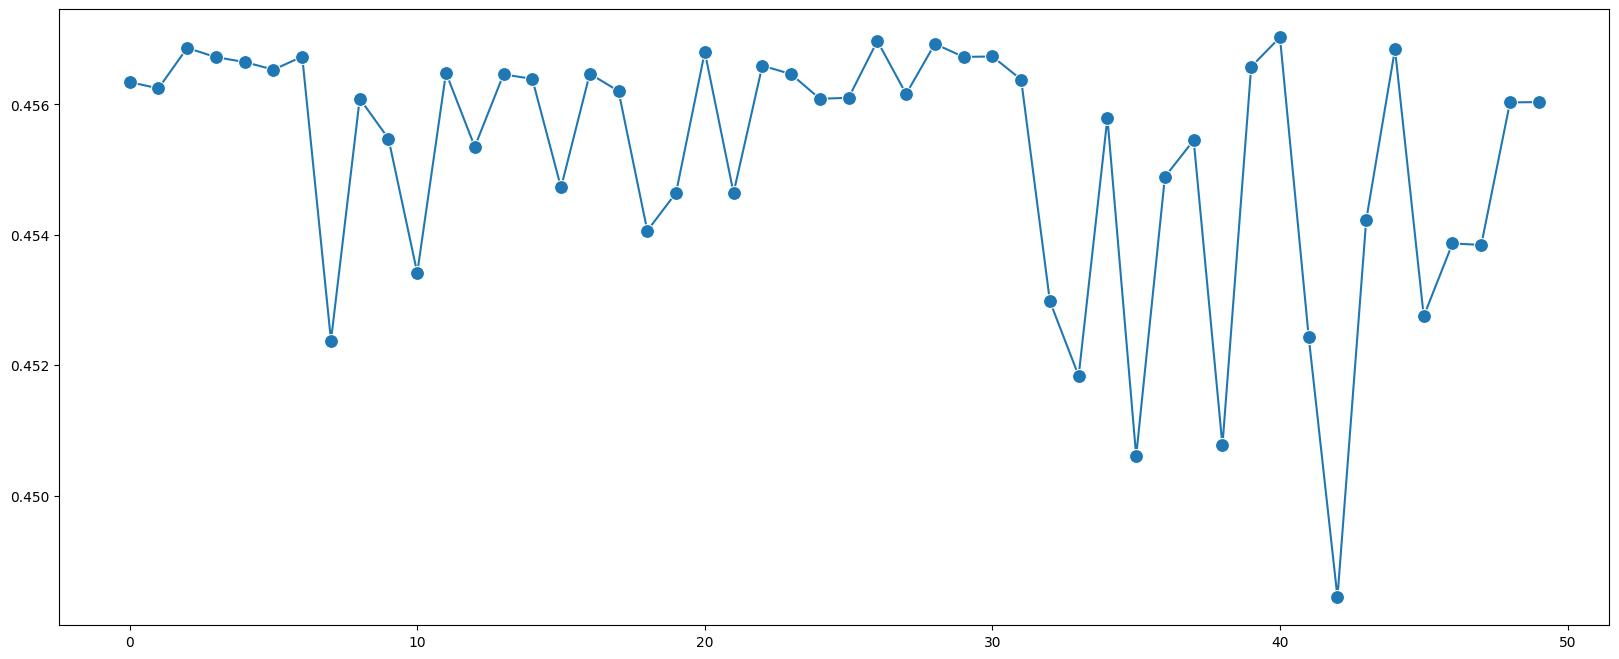

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x=range(len(yield_list)), y=yield_list, marker = "o", markersize = 10)
plt.show()

In [ ]:
state_list[-1]

array([-0.5,  0.8, -0.3,  0.8, -0.7,  0.8, -0.7,  0.8, -0.7,  0.8, -0.7,
        0.8, -0.7,  0.8, -0.7,  0.8, -0.3,  0.8, -0.3,  0.8, -0.7,  0.8,
       -0.7,  0.8, -0.7,  0.8, -0.7,  0.8, -0.7,  0.8, -0.3,  0.4, -0.3,
       -1. ,  0.8, -0.8,  0.8,  0.8,  0.8,  0.8,  0.8, -0.7,  0.4, -0.7,
        0.4, -0.7,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,
        0.8,  0.8, -0.7,  0.8, -0.7,  0.8, -0.7,  0.8, -0.7,  0.8, -0.7,
        0.8,  0.8,  0.5,  0.8,  0.8,  0.8,  0.8,  0.8, -0.5,  0.8, -0.5,
       -0.5, -0.5, -0.5, -0.5, -0.6, -0.6,  0.8,  0.8,  0.8,  0.8,  0.8,
        0.8, -0.7, -0.7, -0.7, -0.5, -0.5, -0.5, -0.5,  0.8,  0.8, -0.6,
       -0.6])

## Conclusion and future work
One limitation of our current approach is that it only allows for finite actions. Using the Deep Deterministic Policy Gradient (DDPG) algorithm could address this constrait, as it is designed to handle continuous action spaces, which would allow for more precise control of the magnetic field. Due to the time-intensive nature of the learning process, we've only demonstrated the first 50 episodes, in which minimal optimization, if any, has been achieved. The reinforcement learning process heavily relies on the selection of appropriate hyperparameters and typically require hundreds of episodes. Hence, to truly realize optimization, accelerating the learning procedure and fine-tuning the hyperparameters would likely be beneficial.